In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id, udf, F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType
from pyspark.sql.functions import hour, col, count, avg, min, max

In [ ]:
spark = (SparkSession.builder.appName("FinalProject")
         .config("spark.executor.memory", "4g")
         .config("spark.driver.memory", "4g")
         .config("spark.executor.memoryOverhead", "1g")
         .getOrCreate())

In [ ]:
green = spark.read.csv("csvs/green.csv", header=True, inferSchema=True)
green = green.fillna(0)
green.show(3)

In [4]:
yellow = spark.read.csv("csvs/yellow.csv", header=True, inferSchema=True)
yellow = yellow.fillna(0)   
yellow.show(3)

+-----+--------+--------------------+---------------------+---------------+-------------+------------+------------+----------+------------------+------------+-----------+-----+-------+---------------------+----------+------------+------------+---------+
|index|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|tolls_amount|total_amount|trip_type|
+-----+--------+--------------------+---------------------+---------------+-------------+------------+------------+----------+------------------+------------+-----------+-----+-------+---------------------+----------+------------+------------+---------+
|    0|       2| 2014-10-08 23:25:12|  2014-10-08 23:29:41|            1.0|         0.91|         255|         112|       1.0|                 N|         1.0|        5.5|  0.5|    0.5|                  0.0|       1.5|         0.0|        

In [5]:
print(green.dtypes)

[('index', 'int'), ('VendorID', 'int'), ('tpep_pickup_datetime', 'timestamp'), ('tpep_dropoff_datetime', 'timestamp'), ('passenger_count', 'double'), ('trip_distance', 'double'), ('PULocationID', 'int'), ('DOLocationID', 'int'), ('RatecodeID', 'double'), ('store_and_fwd_flag', 'string'), ('payment_type', 'int'), ('fare_amount', 'double'), ('extra', 'double'), ('mta_tax', 'double'), ('improvement_surcharge', 'double'), ('tip_amount', 'double'), ('tolls_amount', 'double'), ('total_amount', 'double'), ('congestion_surcharge', 'double'), ('airport_fee', 'double')]


In [6]:
green = green.withColumn('store_and_fwd_flag', F.when(green['store_and_fwd_flag'] == 'Y', 1).otherwise(0).cast('int'))
yellow = yellow.withColumn('store_and_fwd_flag', F.when(yellow['store_and_fwd_flag'] == 'Y', 1).otherwise(0).cast('int'))
green.show(3)

+-----+--------+--------------------+---------------------+---------------+-------------+------------+------------+----------+------------------+------------+-----------+-----+-------+---------------------+----------+------------+------------+--------------------+-----------+
|index|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|tolls_amount|total_amount|congestion_surcharge|airport_fee|
+-----+--------+--------------------+---------------------+---------------+-------------+------------+------------+----------+------------------+------------+-----------+-----+-------+---------------------+----------+------------+------------+--------------------+-----------+
|    0|       1| 2014-10-28 16:27:45|  2014-10-28 16:31:06|            1.0|          0.4|         164|         161|       1.0|                 0|           2|        4.0

In [7]:
for column, dtype in green.dtypes:
    if dtype not in ['double', 'int', 'timestamp']:
        print(f"column {column} - dtype {dtype}")
print('done')

done


In [8]:
yellow_avg = yellow.withColumn("pickup_year", F.year("lpep_pickup_datetime")) \
    .filter((F.col("pickup_year") >= 2014) & (F.col("pickup_year") <= 2024)) \
    .groupBy("pickup_year") \
    .agg(
        F.avg("total_amount").alias("avg_total_amount")
    )

green_avg = green.withColumn("pickup_year", F.year("tpep_pickup_datetime")) \
    .filter((F.col("pickup_year") >= 2014) & (F.col("pickup_year") <= 2024)) \
    .groupBy("pickup_year") \
    .agg(
        F.avg("total_amount").alias("avg_total_amount")
    )

yellow_avg.show()
green_avg.show()

+-----------+------------------+
|pickup_year|  avg_total_amount|
+-----------+------------------+
|       2015|14.790377128216464|
|       2014|14.687699973941061|
|       2016|14.671467530223408|
|       2018|15.613872288728093|
|       2019|13.961457035993936|
|       2017|14.229321513135776|
|       2020| 20.16361503421532|
|       2021|23.932869689210197|
|       2022|19.322287855392517|
|       2023| 23.85673650507884|
|       2024| 23.91275068841723|
+-----------+------------------+



+-----------+------------------+
|pickup_year|  avg_total_amount|
+-----------+------------------+
|       2015|16.021276424826848|
|       2014|15.323022858179055|
|       2016|17.065817889054813|
|       2017|16.327871289353713|
|       2018| 16.46024126576139|
|       2019|19.214629845498994|
|       2020|  18.2685762876947|
|       2022| 21.69386233210051|
|       2021|19.637017095836107|
|       2023| 28.43028325322384|
|       2024|27.598453103826717|
+-----------+------------------+



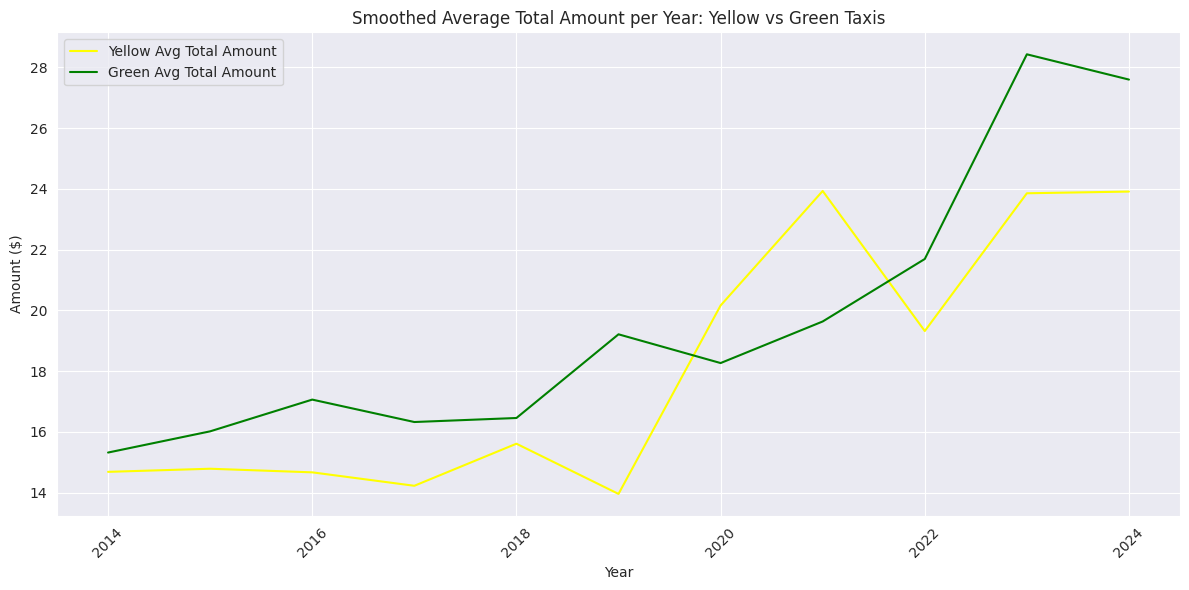

In [9]:
import matplotlib.pyplot as plt

yellow_avg_pandas = yellow_avg.toPandas()
green_avg_pandas = green_avg.toPandas()

yellow_avg_pandas = yellow_avg_pandas.sort_values(by="pickup_year")
green_avg_pandas = green_avg_pandas.sort_values(by="pickup_year")

plt.figure(figsize=(12, 6))
plt.plot(yellow_avg_pandas['pickup_year'], yellow_avg_pandas['avg_total_amount'], label="Yellow Avg Total Amount", color='yellow')
plt.plot(green_avg_pandas['pickup_year'], green_avg_pandas['avg_total_amount'], label="Green Avg Total Amount", color='green')

plt.xlabel('Year')
plt.ylabel('Amount ($)')
plt.title('Smoothed Average Total Amount per Year: Yellow vs Green Taxis')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

vendors = green.filter(green["VendorID"].isin(1, 2))

vendor_comparison = vendors.groupBy("VendorID").agg(
    avg("trip_distance").alias("avg_trip_distance"),
    avg("fare_amount").alias("avg_fare_amount"),
    count("VendorID").alias("trip_count")
)

vendor_comparison.show()

+--------+-----------------+------------------+----------+
|VendorID|avg_trip_distance|   avg_fare_amount|trip_count|
+--------+-----------------+------------------+----------+
|       1|7.983318507544191|13.703900194791832|   4093093|
|       2|4.198500200235064|14.804820593950142|   6951828|
+--------+-----------------+------------------+----------+



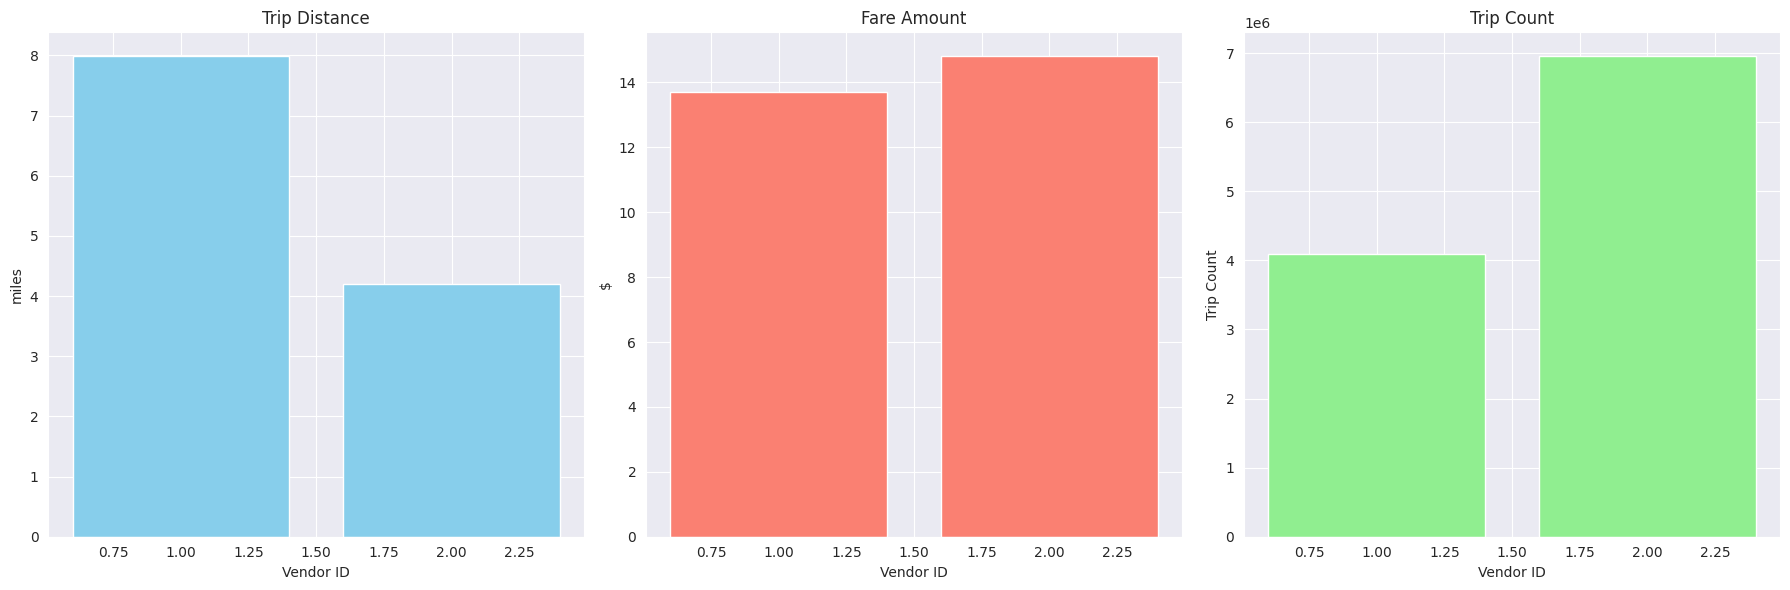

In [11]:
vendor_comparison_pandas = vendor_comparison.toPandas()

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].bar(vendor_comparison_pandas["VendorID"], vendor_comparison_pandas["avg_trip_distance"], color='skyblue')
ax[0].set_title("Trip Distance")
ax[0].set_xlabel("Vendor ID")
ax[0].set_ylabel("miles")

ax[1].bar(vendor_comparison_pandas["VendorID"], vendor_comparison_pandas["avg_fare_amount"], color='salmon')
ax[1].set_title("Fare Amount")
ax[1].set_xlabel("Vendor ID")
ax[1].set_ylabel("$")

ax[2].bar(vendor_comparison_pandas["VendorID"], vendor_comparison_pandas["trip_count"], color='lightgreen')
ax[2].set_title("Trip Count")
ax[2].set_xlabel("Vendor ID")
ax[2].set_ylabel("Trip Count")

plt.tight_layout()
plt.show()  

In [12]:
green.show(1)

+-----+--------+--------------------+---------------------+---------------+-------------+------------+------------+----------+------------------+------------+-----------+-----+-------+---------------------+----------+------------+------------+--------------------+-----------+
|index|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|tolls_amount|total_amount|congestion_surcharge|airport_fee|
+-----+--------+--------------------+---------------------+---------------+-------------+------------+------------+----------+------------------+------------+-----------+-----+-------+---------------------+----------+------------+------------+--------------------+-----------+
|    0|       1| 2014-10-28 16:27:45|  2014-10-28 16:31:06|            1.0|          0.4|         164|         161|       1.0|                 0|           2|        4.0

In [ ]:

hourly_data = green.withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
    .groupBy("pickup_hour") \
    .agg(
        count("tpep_pickup_datetime").alias("trip_count"),
        avg("fare_amount").alias("avg_fare_amount")
    )

min_trip_count = hourly_data.agg(min("trip_count")).collect()[0][0]
max_trip_count = hourly_data.agg(max("trip_count")).collect()[0][0]
min_fare = hourly_data.agg(min("avg_fare_amount")).collect()[0][0]
max_fare = hourly_data.agg(max("avg_fare_amount")).collect()[0][0]

efficiency = hourly_data.withColumn(
    "normalized_trip_count", 
    1 - ((col("trip_count") - min_trip_count) / (max_trip_count - min_trip_count))
).withColumn(
    "normalized_avg_fare", 
    (col("avg_fare_amount") - min_fare) / (max_fare - min_fare)
).withColumn(
    "efficiency_index", 
    col("normalized_trip_count") * col("normalized_avg_fare")
)

efficiency = efficiency.orderBy(col("efficiency_index").desc())

efficiency.show()

+-----------+----------+------------------+---------------------+-------------------+--------------------+
|pickup_hour|trip_count|   avg_fare_amount|normalized_trip_count|normalized_avg_fare|    efficiency_index|
+-----------+----------+------------------+---------------------+-------------------+--------------------+
|          5|     94210|18.310570427767757|    0.992028608196242|                1.0|   0.992028608196242|
|          4|     89112|17.132864709578953|                  1.0| 0.7583434847985426|  0.7583434847985426|
|          1|    237135|16.645056191620817|   0.7685466204457287| 0.6582487797166636|  0.5058948750637667|
|          6|    214810|15.013878590382207|   0.8034546867499457| 0.3235431833167307|  0.2599522870018241|
|          0|    338543|14.829204207441913|   0.6099819087871382| 0.2856493638853671| 0.17424094422662806|
|          3|    117747|14.213977001537193|   0.9552254208904254|0.15940928511194516| 0.15227180146489963|
|         23|    463427|15.0324760102

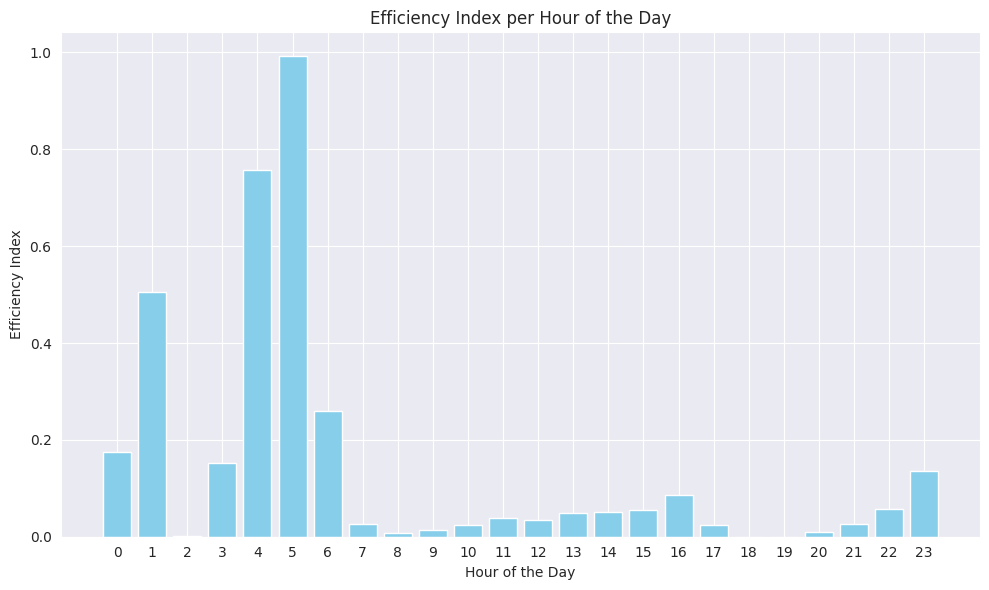

In [14]:
efficiency_pandas = efficiency.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(efficiency_pandas["pickup_hour"], efficiency_pandas["efficiency_index"], color='skyblue')
plt.xlabel("Hour of the Day")
plt.ylabel("Efficiency Index")
plt.title("Efficiency Index per Hour of the Day")
plt.xticks(range(24))
plt.tight_layout()
plt.show()

In [15]:
# The understanding when trips are longer, when traffic is worse, and how trip speeds vary throughout the day
df = green.withColumn("trip_duration", (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) / 60)
df = df.withColumn("avg_speed", (F.col("trip_distance") / F.col("trip_duration")) * 60 * 1.6)

df = df.withColumn("pickup_hour", F.hour("tpep_pickup_datetime"))

q1 = df.approxQuantile("trip_distance", [0.25], 0.01)[0]
q3 = df.approxQuantile("trip_distance", [0.75], 0.01)[0]
iqr = q3 - q1

df_filtered = df.filter(
    (F.col("trip_distance") >= (q1 - 1.5 * iqr)) & (F.col("trip_distance") <= (q3 + 1.5 * iqr))
)

result = df_filtered.groupBy("pickup_hour").agg(
    F.avg("trip_distance").alias("avg_trip_distance"),
    F.avg("trip_duration").alias("avg_trip_duration"),
    F.avg("avg_speed").alias("avg_speed")
)

result.show()

+-----------+------------------+------------------+------------------+
|pickup_hour| avg_trip_distance| avg_trip_duration|         avg_speed|
+-----------+------------------+------------------+------------------+
|         12| 1.751983895260608|14.335476694868545|15.378309772523208|
|         22| 2.164655589087293|13.157260743382713|20.579916105273405|
|          1|2.2950065331847362|13.260342207575945| 24.11790670715018|
|         13|1.7562120415308047|14.453315715795437| 15.19736334729846|
|         16|1.7846077496069421|14.606879900426934|15.775824321216412|
|          6|1.9296166397062562|10.114436135537174|24.072492840954478|
|          3|2.3613420665554425|11.709520659960452|28.367808985348166|
|         20|1.9756004969052532|12.720687440167941|18.822502158152812|
|          5| 2.069712820808251| 9.962114382003062|30.418402135562612|
|         19|1.8663249888976858|13.279051862292691|17.396948857856202|
|         15|1.7662904509307649|16.116027924427517|15.219117000351899|
|     

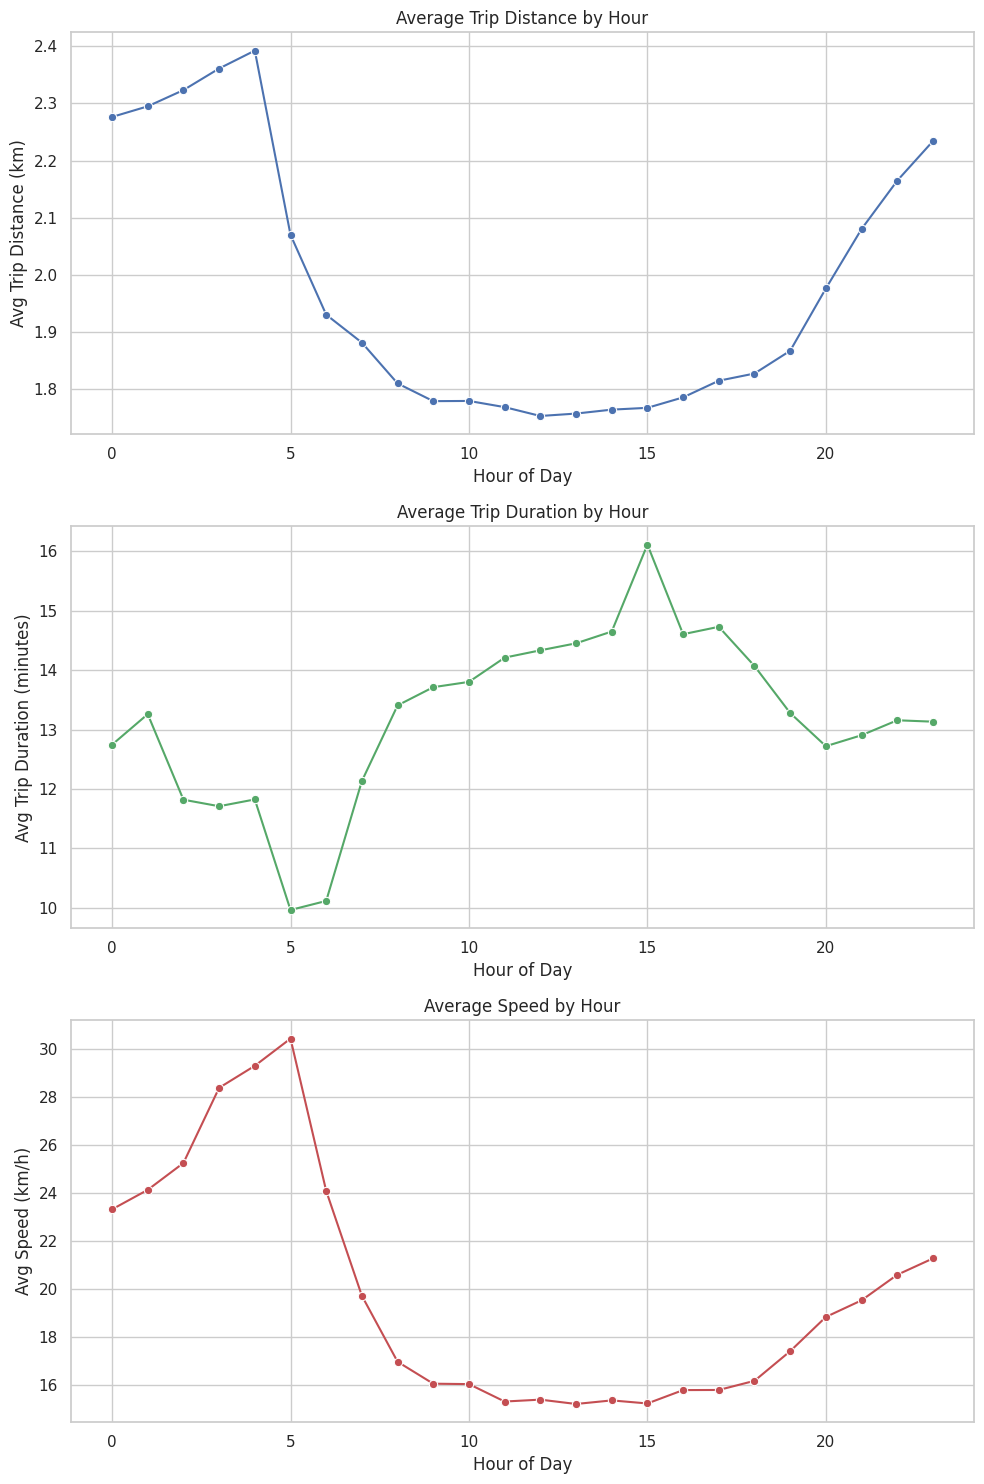

In [47]:
result_pandas = result.toPandas()

sns.set(style="whitegrid")

fig, ax = plt.subplots(3, 1, figsize=(10, 15))  

sns.lineplot(data=result_pandas, x="pickup_hour", y="avg_trip_distance", ax=ax[0], marker="o", color='b')
ax[0].set_title('Average Trip Distance by Hour')
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Avg Trip Distance (km)')  

sns.lineplot(data=result_pandas, x="pickup_hour", y="avg_trip_duration", ax=ax[1], marker="o", color='g')
ax[1].set_title('Average Trip Duration by Hour')
ax[1].set_xlabel('Hour of Day')
ax[1].set_ylabel('Avg Trip Duration (minutes)')

sns.lineplot(data=result_pandas, x="pickup_hour", y="avg_speed", ax=ax[2], marker="o", color='r')
ax[2].set_title('Average Speed by Hour')
ax[2].set_xlabel('Hour of Day')
ax[2].set_ylabel('Avg Speed (km/h)')

plt.tight_layout()
plt.show()

In [17]:
# Distribution of trips based on the number of passengers
df_filtered = df.filter(df.passenger_count <= 5)

passenger_count_distribution = df_filtered.groupBy("passenger_count").count().orderBy("passenger_count")
passenger_count_distribution.show()

total_trips = df.count()
trips_with_more_than_one_passenger = df_filtered.filter(df.passenger_count > 1).count()
percentage_more_than_one = (trips_with_more_than_one_passenger / total_trips) * 100

print(f"Percentage of trips with more than one passenger: {percentage_more_than_one:.2f}%")

fare_by_passenger_count = df_filtered.groupBy("passenger_count").agg(
    F.avg("fare_amount").alias("avg_fare_amount"),
    F.count("fare_amount").alias("trip_count")
).orderBy("passenger_count")

fare_by_passenger_count.show()

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|            0.0| 123720|
|            1.0|8013953|
|            2.0|1620081|
|            3.0| 442386|
|            4.0| 215342|
|            5.0| 395619|
+---------------+-------+



Percentage of trips with more than one passenger: 24.17%


+---------------+------------------+----------+
|passenger_count|   avg_fare_amount|trip_count|
+---------------+------------------+----------+
|            0.0|14.711763013255755|    123720|
|            1.0|14.220053616485563|   8013953|
|            2.0|15.374694691191415|   1620081|
|            3.0|15.002044594539607|    442386|
|            4.0|15.983402401760948|    215342|
|            5.0|13.443192819353975|    395619|
+---------------+------------------+----------+



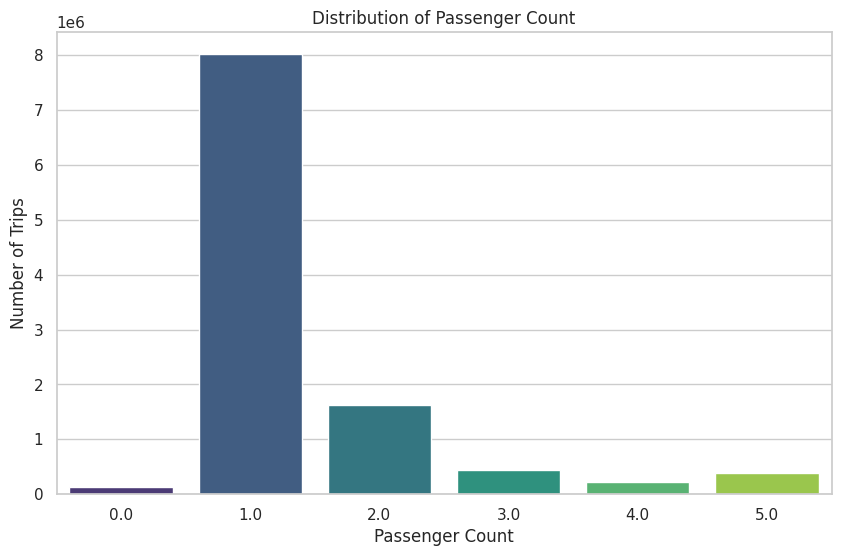

In [18]:
passenger_count_dist_pd = passenger_count_distribution.toPandas()
fare_by_passenger_count_pd = fare_by_passenger_count.toPandas()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(data=passenger_count_dist_pd, x="passenger_count", y="count", palette="viridis")
plt.title("Distribution of Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Number of Trips")

plt.show()

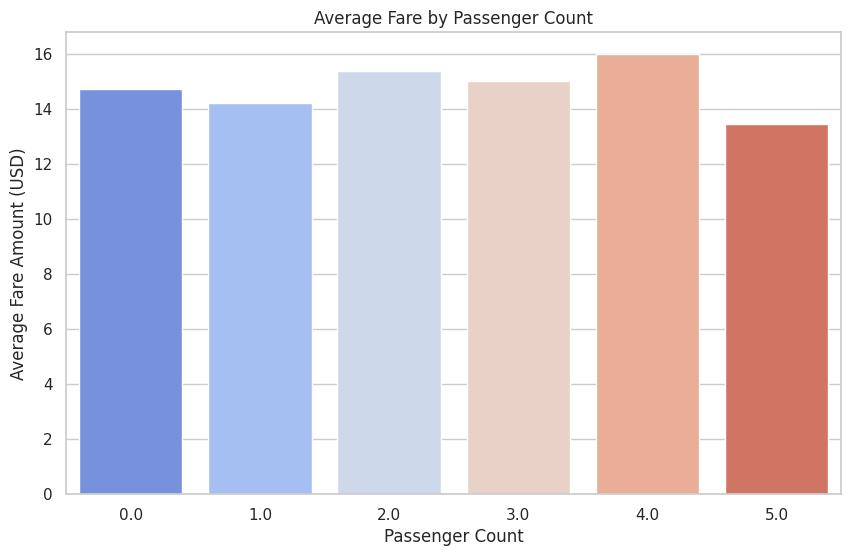

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(data=fare_by_passenger_count_pd, x="passenger_count", y="avg_fare_amount", palette="coolwarm")
plt.title("Average Fare by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Average Fare Amount (USD)")

plt.show()

In [20]:
regions = {
    "Manhattan": [103, 104, 105, 12, 88, 261, 13, 87, 209, 45, 231, 232, 144, 148, 125, 211, 4, 79, 113, 114, 249, 158, 224, 107, 234, 137, 90, 68, 246, 186, 
                  164, 100, 170, 233, 50, 48, 230, 161, 162, 229, 202, 140, 141, 237, 236, 263, 262, 43, 142, 143, 239, 238, 151, 24, 75, 74, 194, 41, 166, 42,
                  152, 116, 244, 120, 243, 127, 128, 153],
    "Bronx": [259, 200, 240, 254, 81, 51, 184, 46, 220, 241, 18, 174, 32, 3, 136, 18, 20, 31, 185, 183, 58, 94, 235, 169, 119, 247, 69, 159, 168, 167, 47, 78, 
              59, 60, 126, 199, 213, 212, 248, 182, 250, 208, 242],
    "Brooklyn": [55, 29, 150, 154, 210, 108, 21, 123, 149, 155, 11, 22, 67, 14, 228, 227, 26, 178, 165, 91, 111, 133, 257, 89, 85, 71, 39, 222, 76, 35, 77, 63, 
                 72, 188, 190, 181, 106, 195, 40, 62, 189, 61, 177, 54, 52, 25, 33, 65, 66, 97, 49, 34, 17, 225, 36, 37, 256, 80, 255, 112, 217],
    "Queens": [27, 201, 117, 86, 30, 2, 124, 132, 203, 219, 180, 216, 10, 218, 139, 258, 197, 130, 215, 205, 38, 191, 122, 19, 101, 96, 134, 28, 131, 102,
               198, 64, 15, 16, 175, 252, 171, 9, 98, 171, 73, 192, 121, 53, 253, 92, 135, 93, 57, 196, 95, 160, 157, 82, 83, 260, 226, 129, 56, 173, 70, 138, 207, 
               145, 146, 193, 179, 8, 7, 223],
    "Staten Island": [44, 204, 84, 5, 99, 109, 110, 176, 172, 214, 6, 221, 118, 23, 156, 187, 251, 115, 245, 206]
}

In [ ]:
def get_region(neighborhood_id):
    for region, neighborhoods in regions.items():
        if neighborhood_id in neighborhoods:
            return region
    return None



region_udf = udf(get_region, StringType())
df_with_region = df.withColumn("PULocationRegion", region_udf(F.col("PULocationID"))) \
                   .withColumn("DOLocationRegion", region_udf(F.col("DOLocationID")))

fare_by_region = df_with_region.groupBy("PULocationRegion").agg(
    F.avg("fare_amount").alias("avg_fare_amount"),
    F.count("fare_amount").alias("trip_count")
)

fare_by_region.show()

+----------------+------------------+----------+
|PULocationRegion|   avg_fare_amount|trip_count|
+----------------+------------------+----------+
|          Queens|39.455930979644435|    769657|
|            NULL| 16.65193434128391|    441556|
|        Brooklyn|18.634067954073895|    156076|
|   Staten Island|54.186456310679596|       618|
|       Manhattan|12.216139020759073|   9669635|
|           Bronx|26.632007419273204|     23722|
+----------------+------------------+----------+



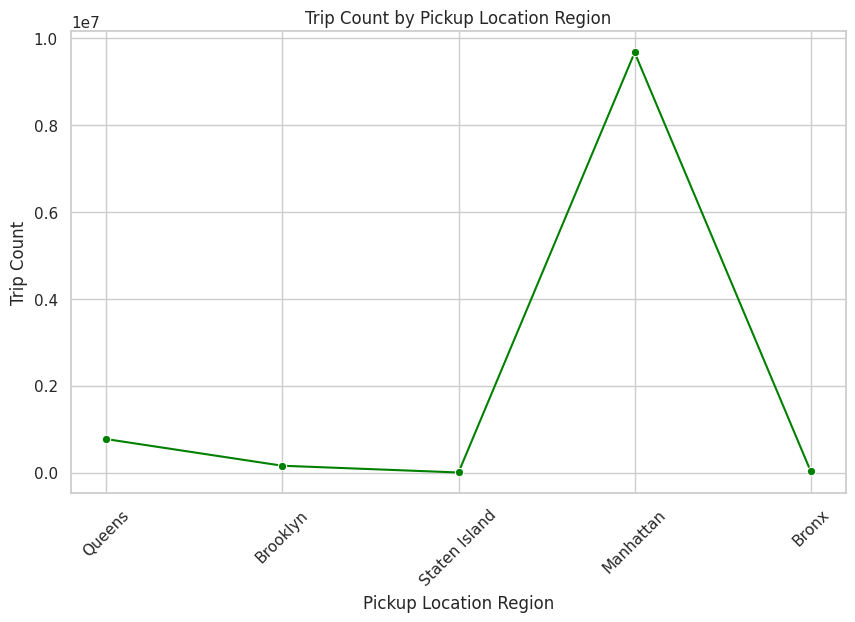

In [26]:
fare_by_region_pd = fare_by_region.toPandas()
plt.figure(figsize=(10, 6))
sns.lineplot(data=fare_by_region_pd, x="PULocationRegion", y="trip_count", marker="o", color="green")
plt.title("Trip Count by Pickup Location Region")
plt.xlabel("Pickup Location Region")
plt.ylabel("Trip Count")

plt.xticks(rotation=45)
plt.show()

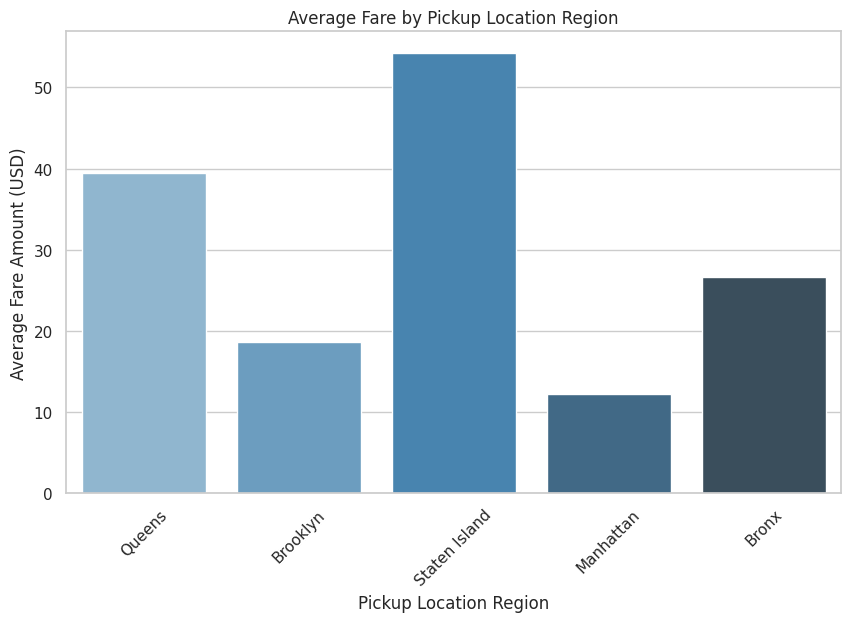

In [27]:
fare_by_region_pd = fare_by_region.toPandas()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(data=fare_by_region_pd, x="PULocationRegion", y="avg_fare_amount", palette="Blues_d")
plt.title("Average Fare by Pickup Location Region")
plt.xlabel("Pickup Location Region")
plt.ylabel("Average Fare Amount (USD)")

plt.xticks(rotation=45)
plt.show()

In [53]:
get_region_udf = F.udf(get_region, StringType())
df_with_region = df.withColumn("Region", get_region_udf(F.col("PULocationID")))

tips_by_region = df_with_region.groupBy("Region").agg(
    F.avg("Tip_amount").alias("Avg_Tip_Amount"),
    F.count("*").alias("Total_Trips"),
    F.sum(F.when(F.col("Tip_amount") > 0, 1).otherwise(0)).alias("Trips_With_Tips"))

tips_by_region = tips_by_region.withColumn(
    "Tip_Trip_Percentage", (F.col("Trips_With_Tips") / F.col("Total_Trips")) * 100)

tips_by_region.orderBy(F.col("Avg_Tip_Amount").desc()).show()

+-------------+------------------+-----------+---------------+-------------------+
|       Region|    Avg_Tip_Amount|Total_Trips|Trips_With_Tips|Tip_Trip_Percentage|
+-------------+------------------+-----------+---------------+-------------------+
|       Queens| 5.828235681608637|     769657|         477600| 62.053616091323796|
|         NULL|2.2450960920019667|     441556|         286902|  64.97522398065024|
|    Manhattan| 1.992254400502672|    9669635|        6639659|  68.66504268258315|
|     Brooklyn|1.8277601296804142|     156076|          79402| 50.873933212024916|
|Staten Island|1.6128640776699028|        618|            155| 25.080906148867317|
|        Bronx|0.9286265913498017|      23722|           5741| 24.201163476941236|
+-------------+------------------+-----------+---------------+-------------------+



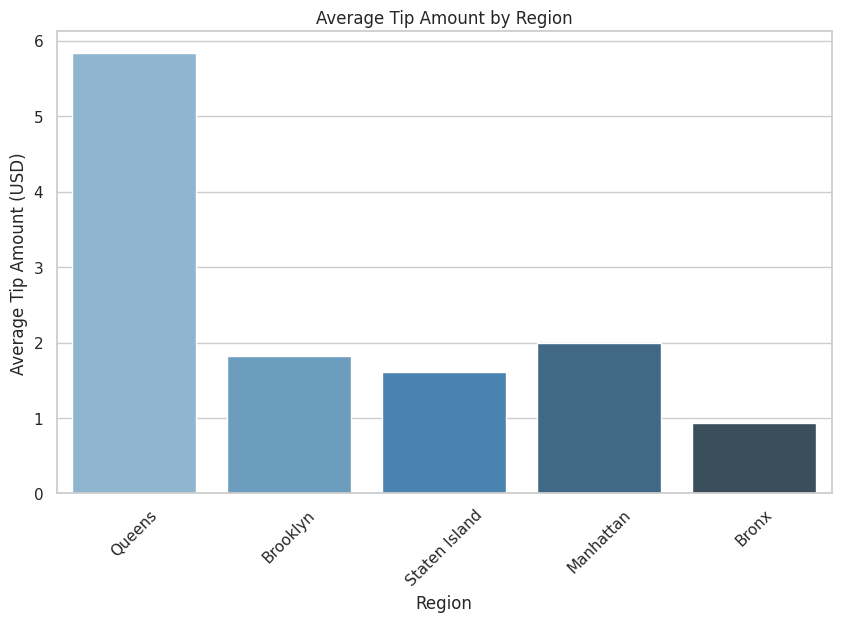

In [ ]:
tips_by_region_pd = tips_by_region.toPandas()


sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(data=tips_by_region_pd, x="Region", y="Avg_Tip_Amount", palette="Blues_d")
plt.title("Average Tip Amount by Region")
plt.xlabel("Region")
plt.ylabel("Average Tip Amount (USD)")

plt.xticks(rotation=45)
plt.show()

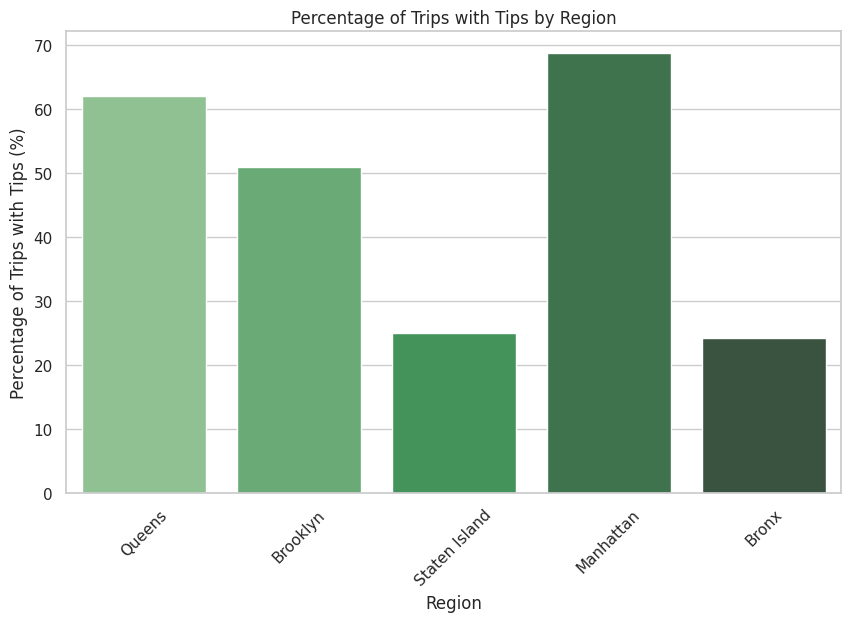

In [55]:
plt.figure(figsize=(10, 6))
sns.barplot(data=tips_by_region_pd, x="Region", y="Tip_Trip_Percentage", palette="Greens_d")
plt.title("Percentage of Trips with Tips by Region")
plt.xlabel("Region")
plt.ylabel("Percentage of Trips with Tips (%)")

plt.xticks(rotation=45)
plt.show()


In [ ]:
df = green.withColumn("trip_duration", (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) / 60)
df = df.withColumn("avg_speed", (F.col("trip_distance") / F.col("trip_duration")) * 60 * 1.6)

df = df.withColumn("pickup_hour", F.hour("tpep_pickup_datetime"))

q1 = df.approxQuantile("trip_distance", [0.25], 0.01)[0]
q3 = df.approxQuantile("trip_distance", [0.75], 0.01)[0]
iqr = q3 - q1

df_filtered = df.filter(
    (F.col("trip_distance") >= (q1 - 1.5 * iqr)) & (F.col("trip_distance") <= (q3 + 1.5 * iqr))
)

result_by_hour = df_filtered.groupBy("pickup_hour").agg(
    F.avg("trip_distance").alias("avg_trip_distance"),
    F.avg("trip_duration").alias("avg_trip_duration"),
    F.avg("avg_speed").alias("avg_speed"),
    F.avg("Tip_amount").alias("avg_tip_amount")
)

result_by_hour.show()

+-----------+------------------+------------------+------------------+------------------+
|pickup_hour| avg_trip_distance| avg_trip_duration|         avg_speed|    avg_tip_amount|
+-----------+------------------+------------------+------------------+------------------+
|         12| 1.751983895260608|14.335476694868545|15.378309772523208|  1.69395323918436|
|         22| 2.164655589087293|13.157260743382713|20.579916105273405|1.8953394483938708|
|          1|2.2950065331847362|13.260342207575945| 24.11790670715018|1.7358632931094202|
|         13|1.7562120415308047|14.453315715795437| 15.19736334729846|1.6888994297778268|
|         16|1.7846077496069421|14.606879900426934|15.775824321216412|1.8762434364172476|
|          6|1.9296166397062562|10.114436135537174|24.072492840954478|1.3546700661043305|
|          3|2.3613420665554425|11.709520659960452|28.367808985348166|1.6170482433192817|
|         20|1.9756004969052532|12.720687440167941|18.822502158152812|1.8328814866416163|
|         

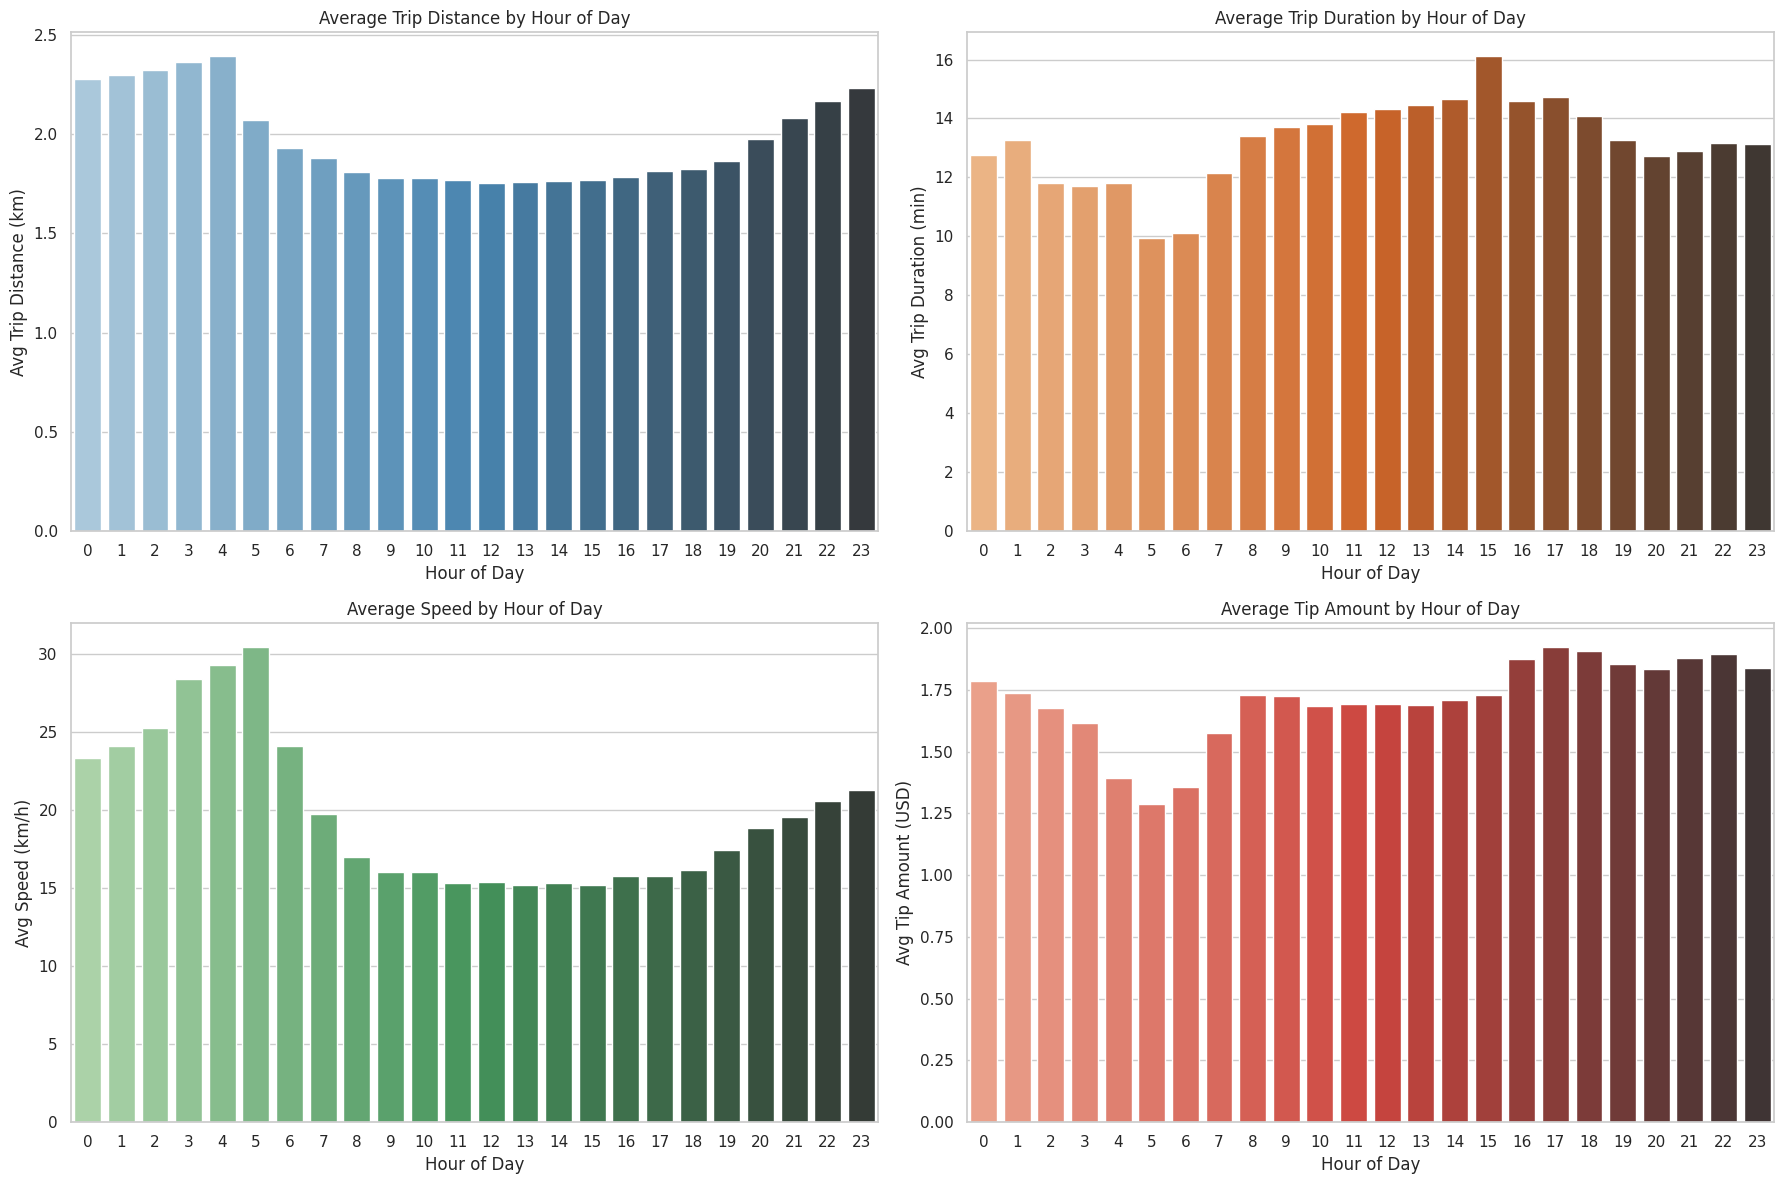

In [52]:
result_by_hour_pd = result_by_hour.toPandas()

sns.set(style="whitegrid")

fig, ax = plt.subplots(2, 2, figsize=(18, 12))

sns.barplot(data=result_by_hour_pd, x="pickup_hour", y="avg_trip_distance", palette="Blues_d", ax=ax[0, 0])
ax[0, 0].set_title("Average Trip Distance by Hour of Day")
ax[0, 0].set_xlabel("Hour of Day")
ax[0, 0].set_ylabel("Avg Trip Distance (km)")

sns.barplot(data=result_by_hour_pd, x="pickup_hour", y="avg_trip_duration", palette="Oranges_d", ax=ax[0, 1])
ax[0, 1].set_title("Average Trip Duration by Hour of Day")
ax[0, 1].set_xlabel("Hour of Day")
ax[0, 1].set_ylabel("Avg Trip Duration (min)")
6
sns.barplot(data=result_by_hour_pd, x="pickup_hour", y="avg_speed", palette="Greens_d", ax=ax[1, 0])
ax[1, 0].set_title("Average Speed by Hour of Day")
ax[1, 0].set_xlabel("Hour of Day")
ax[1, 0].set_ylabel("Avg Speed (km/h)")

sns.barplot(data=result_by_hour_pd, x="pickup_hour", y="avg_tip_amount", palette="Reds_d", ax=ax[1, 1])
ax[1, 1].set_title("Average Tip Amount by Hour of Day")
ax[1, 1].set_xlabel("Hour of Day")
ax[1, 1].set_ylabel("Avg Tip Amount (USD)")

plt.tight_layout()

plt.show()

In [56]:
df = green.withColumn("trip_duration", (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) / 60)
df = df.withColumn("avg_speed", (F.col("trip_distance") / F.col("trip_duration")) * 60 * 1.6)

df = df.withColumn(
    "Speed_Range",
    F.when(F.col("avg_speed") < 10, "< 10 km/h")
    .when((F.col("avg_speed") >= 10) & (F.col("avg_speed") < 20), "10-20 km/h")
    .when((F.col("avg_speed") >= 20) & (F.col("avg_speed") < 30), "20-30 km/h")
    .when((F.col("avg_speed") >= 30) & (F.col("avg_speed") < 40), "30-40 km/h")
    .when((F.col("avg_speed") >= 40) & (F.col("avg_speed") < 50), "40-50 km/h")
    .otherwise("> 50 km/h")
)

tips_by_speed = df.groupBy("Speed_Range").agg(F.avg("Tip_amount").alias("Avg_Tip_Amount"),
    F.count("*").alias("Total_Trips"),
    F.sum(F.when(F.col("Tip_amount") > 0, 1).otherwise(0)).alias("Trips_With_Tips")
)

tips_by_speed = tips_by_speed.withColumn(
    "Tip_Trip_Percentage", (F.col("Trips_With_Tips") / F.col("Total_Trips")) * 100
)

tips_by_speed.orderBy(F.col("Avg_Tip_Amount").desc()).show()

+-----------+------------------+-----------+---------------+-------------------+
|Speed_Range|    Avg_Tip_Amount|Total_Trips|Trips_With_Tips|Tip_Trip_Percentage|
+-----------+------------------+-----------+---------------+-------------------+
|  > 50 km/h| 6.239123491367835|     226364|         141280|  62.41275114417487|
| 40-50 km/h| 5.205164282679485|     310684|         206965|  66.61591842515224|
| 30-40 km/h| 3.872507601625024|     743591|         499802|  67.21463815457692|
| 20-30 km/h|2.4253088434241388|    2330647|        1612750|  69.19752326285362|
|  < 10 km/h|1.8105826645146301|    1628244|        1003185| 61.611466094762214|
| 10-20 km/h|1.8104744892155753|    5821734|        4025477|  69.14567034495221|
+-----------+------------------+-----------+---------------+-------------------+



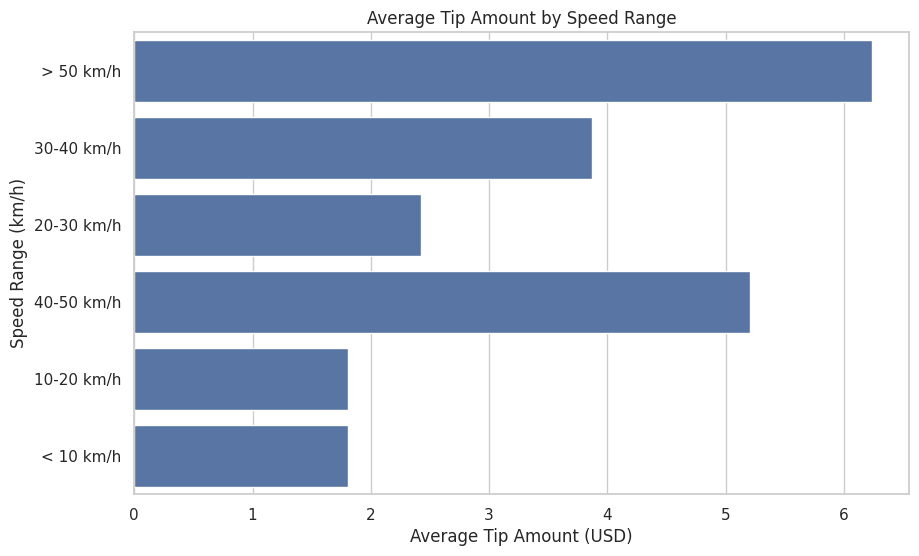

In [76]:
tips_by_speed_pd = tips_by_speed.toPandas()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(data=tips_by_speed_pd, x="Avg_Tip_Amount", y="Speed_Range", orient="h")
sns.color_palette('rocket', as_cmap=True)
plt.title("Average Tip Amount by Speed Range")
plt.xlabel("Average Tip Amount (USD)")
plt.ylabel("Speed Range (km/h)")

plt.show()

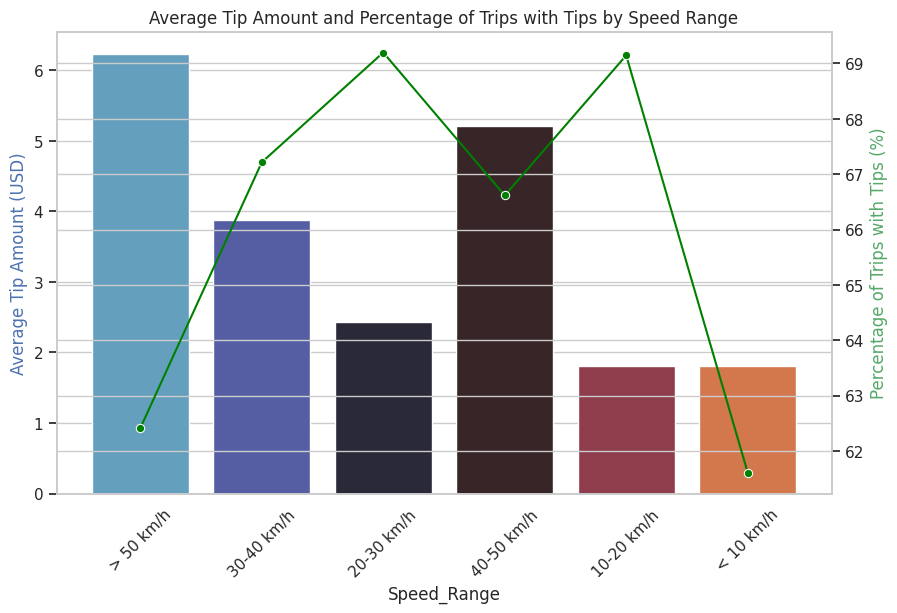

In [78]:
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(data=tips_by_speed_pd, x="Speed_Range", y="Avg_Tip_Amount", palette="Blues_d", ax=ax1)
ax1.set_ylabel("Average Tip Amount (USD)", color='b')
ax1.set_title("Average Tip Amount and Percentage of Trips with Tips by Speed Range")
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
sns.lineplot(data=tips_by_speed_pd, x="Speed_Range", y="Tip_Trip_Percentage", marker="o", color="green", ax=ax2)
ax2.set_ylabel("Percentage of Trips with Tips (%)", color='g')

plt.show()